In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import LogisticHazard

from pycox.evaluation import EvalSurv
from pycox.simulations import SimStudyLinearPH

import torch
import torchtuples as tt

# Read data

In [2]:
df_train = pd.read_csv('train.csv')
df_train = pd.DataFrame(df_train)

df_test = pd.read_csv('test.csv')
df_test = pd.DataFrame(df_test)

In [3]:
df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,Male,41,65,Ileocecal Junction,II,29,1,T3,N1a,M0,IIIB,110,0
1,Male,54,95,Ascending Colon,II,37,0,T4a,N0,M0,IIB,107,0
2,Female,78,65,Sigmoid Colon,II,20,2,T4b,N1b,M0,IIIC,106,0
3,Female,33,150,"Large Intestine, NOS",II,9,0,T4a,N0,M0,IIB,105,0
4,Male,58,100,Descending Colon,III,6,1,T4a,N1a,M0,IIIB,102,0


In [4]:
# to label encoding categorical variables
le = LabelEncoder() #label encoder
cat_list = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #list of categorical variables
for cat in cat_list:
    df_train[cat] = le.fit_transform(df_train[cat])
    df_test[cat] = le.fit_transform(df_test[cat])

df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,1,41,65,3,1,29,1,2,2,0,7,110,0
1,1,54,95,0,1,37,0,4,0,0,3,107,0
2,0,78,65,7,1,20,2,5,3,0,8,106,0
3,0,33,150,4,1,9,0,4,0,0,3,105,0
4,1,58,100,1,2,6,1,4,2,0,7,102,0


In [5]:
# function to get targets variable
get_target = lambda df: (df['duration'].values, df['event'].values)

# to standardize and get dependent variables 
cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

y_train = labtrans.fit_transform(*get_target(df_train))
y_test = labtrans.transform(*get_target(df_test))

train = (x_train, y_train)
val = (x_test, y_test)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

# Neural Network

In [7]:
in_features = x_train.shape[1]
num_nodes = [16,8]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.4
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = LogisticHazard(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 4.4077,	val_loss: 3.9356
1:	[0s / 0s],		train_loss: 3.9672,	val_loss: 3.7713
2:	[0s / 0s],		train_loss: 3.7077,	val_loss: 3.3992
3:	[0s / 0s],		train_loss: 3.3502,	val_loss: 3.0286
4:	[0s / 0s],		train_loss: 3.1223,	val_loss: 2.6010
5:	[0s / 0s],		train_loss: 2.8804,	val_loss: 2.2497
6:	[0s / 0s],		train_loss: 2.5986,	val_loss: 1.9415
7:	[0s / 0s],		train_loss: 2.1887,	val_loss: 1.6506
8:	[0s / 0s],		train_loss: 1.8438,	val_loss: 1.4767
9:	[0s / 0s],		train_loss: 1.8241,	val_loss: 1.3597
10:	[0s / 0s],		train_loss: 1.5679,	val_loss: 1.2938
11:	[0s / 0s],		train_loss: 1.5947,	val_loss: 1.2644
12:	[0s / 0s],		train_loss: 1.4760,	val_loss: 1.2490
13:	[0s / 0s],		train_loss: 1.5235,	val_loss: 1.2370
14:	[0s / 0s],		train_loss: 1.5520,	val_loss: 1.2299
15:	[0s / 0s],		train_loss: 1.5322,	val_loss: 1.2214
16:	[0s / 0s],		train_loss: 1.5616,	val_loss: 1.2138
17:	[0s / 0s],		train_loss: 1.5417,	val_loss: 1.2126
18:	[0s / 0s],		train_loss: 1.4965,	val_loss: 1.2137
19:

0.6993329912775782

<Figure size 864x864 with 0 Axes>

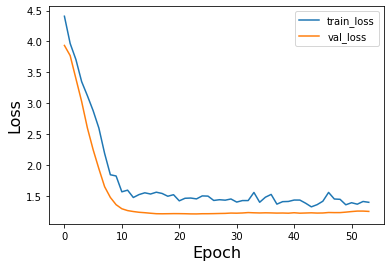

In [8]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.16563044844458497

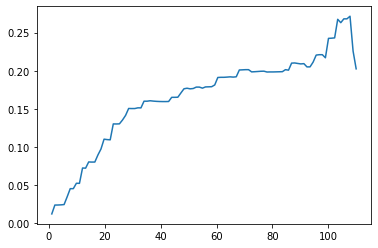

In [11]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

# Internal validation

In [10]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.7301367243522325

0.36753669417234747

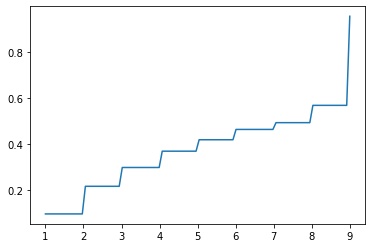

In [12]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

# Save

In [35]:
model_cox.save_model_weights('myweights_LogisticHazard.pt')

# Bootstrap

In [14]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.7320334155720881
The C-index Low 95% CI:0.7300882787409693
The C-index High 95% CI:0.733978552403207


In [15]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.705538749470446
The C-index Low 95% CI:0.7030387975367766
The C-index High 95% CI:0.7080387014041155


# LASSO var

In [16]:
df_train_lasso = df_train[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_test_lasso = df_test[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_train_lasso.head()

,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage
0,41,65,3,1,29,1,2,2,0,7
1,54,95,0,1,37,0,4,0,0,3
2,78,65,7,1,20,2,5,3,0,8
3,33,150,4,1,9,0,4,0,0,3
4,58,100,1,2,6,1,4,2,0,7


In [18]:

# to standardize and get dependent variables 
cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)


x_train = x_mapper.fit_transform(df_train_lasso).astype('float32')
x_test = x_mapper.transform(df_test_lasso).astype('float32')

num_durations = 10

train = (x_train, y_train)
val = (x_test, y_test)


In [19]:
in_features = x_train.shape[1]
num_nodes = [16,4]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.4
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = LogisticHazard(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 4.4095,	val_loss: 4.0727
1:	[0s / 0s],		train_loss: 4.0961,	val_loss: 3.8781
2:	[0s / 0s],		train_loss: 3.9432,	val_loss: 3.7136
3:	[0s / 0s],		train_loss: 3.6491,	val_loss: 3.5239
4:	[0s / 0s],		train_loss: 3.4416,	val_loss: 3.3178
5:	[0s / 0s],		train_loss: 3.3312,	val_loss: 3.0539
6:	[0s / 0s],		train_loss: 2.9507,	val_loss: 2.7509
7:	[0s / 0s],		train_loss: 2.7082,	val_loss: 2.4163
8:	[0s / 0s],		train_loss: 2.5443,	val_loss: 2.1235
9:	[0s / 0s],		train_loss: 2.2881,	val_loss: 1.8733
10:	[0s / 0s],		train_loss: 2.0680,	val_loss: 1.6757
11:	[0s / 0s],		train_loss: 2.0271,	val_loss: 1.5277
12:	[0s / 0s],		train_loss: 1.8265,	val_loss: 1.4362
13:	[0s / 0s],		train_loss: 1.6902,	val_loss: 1.3722
14:	[0s / 0s],		train_loss: 1.6540,	val_loss: 1.3239
15:	[0s / 0s],		train_loss: 1.6080,	val_loss: 1.2929
16:	[0s / 0s],		train_loss: 1.7503,	val_loss: 1.2700
17:	[0s / 0s],		train_loss: 1.6805,	val_loss: 1.2639
18:	[0s / 0s],		train_loss: 1.5938,	val_loss: 1.2622
19:

0.6803488968701898

<Figure size 864x864 with 0 Axes>

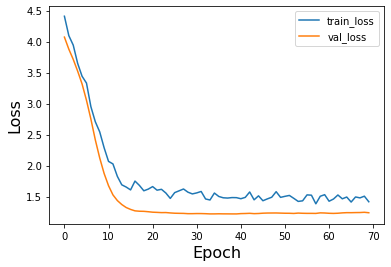

In [20]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.16750501235604776

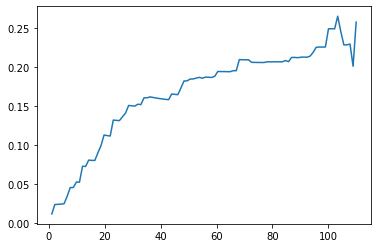

In [21]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [22]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.7208624151448513

0.36945514541353347

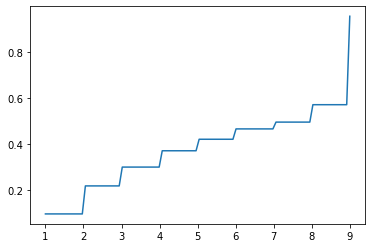

In [23]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [24]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.7216713427392066
The C-index Low 95% CI:0.7196394020270135
The C-index High 95% CI:0.7237032834513998


In [25]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.6866011334585018
The C-index Low 95% CI:0.6839971768347917
The C-index High 95% CI:0.689205090082212


# TNM

In [26]:
df_train_tnm = df_train[["T","N","M","Stage"]]
df_test_tnm = df_test[["T","N","M","Stage"]]
df_train_tnm.head()

,T,N,M,Stage
0,2,2,0,7
1,4,0,0,3
2,5,3,0,8
3,4,0,0,3
4,4,2,0,7


In [27]:
# to standardize and get dependent variables 
cols_leave = ['T', 'N', 'M', 'Stage'] #categorical variables 
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(leave)


x_train = x_mapper.fit_transform(df_train_tnm).astype('float32')
x_test = x_mapper.transform(df_test_tnm).astype('float32')

num_durations = 10

train = (x_train, y_train)
val = (x_test, y_test)


In [28]:
in_features = x_train.shape[1]
num_nodes = [16,4]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.4
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = LogisticHazard(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 4.6355,	val_loss: 4.4012
1:	[0s / 0s],		train_loss: 4.5891,	val_loss: 4.2846
2:	[0s / 0s],		train_loss: 4.1223,	val_loss: 4.0570
3:	[0s / 0s],		train_loss: 3.9785,	val_loss: 3.8121
4:	[0s / 0s],		train_loss: 3.5258,	val_loss: 3.4918
5:	[0s / 0s],		train_loss: 3.3800,	val_loss: 3.1488
6:	[0s / 0s],		train_loss: 3.0750,	val_loss: 2.7666
7:	[0s / 0s],		train_loss: 2.7290,	val_loss: 2.4081
8:	[0s / 0s],		train_loss: 2.6543,	val_loss: 2.1709
9:	[0s / 0s],		train_loss: 2.2983,	val_loss: 1.9187
10:	[0s / 0s],		train_loss: 2.1237,	val_loss: 1.7198
11:	[0s / 0s],		train_loss: 1.9397,	val_loss: 1.5681
12:	[0s / 0s],		train_loss: 1.8715,	val_loss: 1.4591
13:	[0s / 0s],		train_loss: 1.7179,	val_loss: 1.3887
14:	[0s / 0s],		train_loss: 1.7847,	val_loss: 1.3436
15:	[0s / 0s],		train_loss: 1.6645,	val_loss: 1.3188
16:	[0s / 0s],		train_loss: 1.6388,	val_loss: 1.3091
17:	[0s / 0s],		train_loss: 1.5887,	val_loss: 1.3062
18:	[0s / 0s],		train_loss: 1.6600,	val_loss: 1.2981
19:

0.6739353514622883

<Figure size 864x864 with 0 Axes>

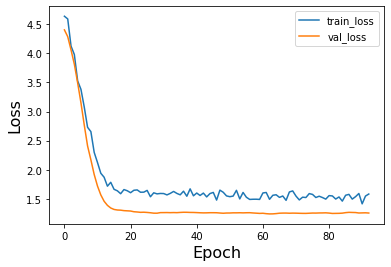

In [29]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.1780123229827252

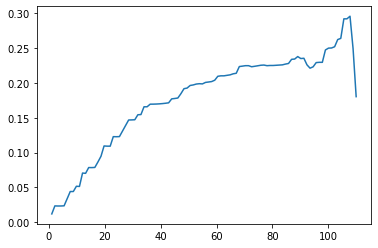

In [30]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [31]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.6729252318577302

0.3764444776699974

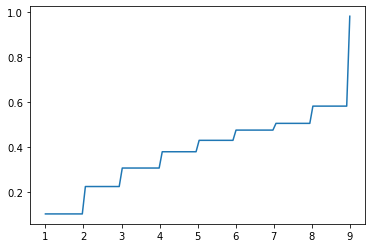

In [32]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [33]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.6766425339053048
The C-index Low 95% CI:0.6743384905380801
The C-index High 95% CI:0.6789465772725295


In [34]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.6664819359223264
The C-index Low 95% CI:0.6638801126751828
The C-index High 95% CI:0.66908375916947
